In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's start out by importing all the libraries we're going to use.

We need numpy to transform our input data into arrays our network can use, and we'll obviously be using several functions from Keras.

We'll also need to use some functions from the Natural Language Toolkit (NLTK) to preprocess our text and get it ready to train on. Finally, we'll need the sys library to handle the printing of our text.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import ifft
#Everything below here was in the example and I'm too afriad to remove them
import requests
import sys
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lets verify the data is proprely read. 

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ICP12/AAPL_2006-01-01_to_2018-01-01.csv")
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
...,...,...,...,...,...,...,...
3014,2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
3015,2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
3016,2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL
3017,2017-12-28,171.00,171.85,170.48,171.08,16480187,AAPL


Let's start by loading in our text data and doing some preprocessing of the data. For this data, we are only gonna care about the 'Close'.


In [4]:
data= df[['Close']]
data

,Close
0,10.68
1,10.71
2,10.63
3,10.90
4,10.86
...,...
3014,175.01
3015,170.57
3016,170.60
3017,171.08


Separate into training and testing.

In [5]:
training = data.iloc[:2900]
test = data.iloc[2900:] #Only have 100 to test. More training = more accurate (theoretically)

In [6]:
#Have to scale the data first because it won't work correctly without it
scale = MinMaxScaler(feature_range=(0,1));
training = scale.fit_transform(training);
#Next we're putting in x(t) and y(t+1)
X = []
y = []
for i in range (len(training)-1):
  X.append(training[i])
  y.append(training[i+1])

In [7]:
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0],X.shape[1],1)) #Need to reshape for model to work
X.shape

(2899, 1, 1)

In [8]:
model = Sequential()
model.add(LSTM(10, input_shape=(X.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dropout(0.2))

We compile the model now, and it is ready for training:

In [9]:
model.compile(loss='mean_squared_error', optimizer='adam') 
#meansquarederror because examples I found online calculated the actual MSE and 
#this is easier

In [10]:
desired_callbacks= ModelCheckpoint('model_saved_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')

Now we'll fit the model and let it train

In [11]:
model.fit(X, y, epochs=200, batch_size=256)

Epoch 1/200
12/12 [==============================] - 6s 6ms/step - loss: 0.2021
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 0.2010
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1998
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1908
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1961
Epoch 6/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1839
Epoch 7/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1809
Epoch 8/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1751
Epoch 9/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1639
Epoch 10/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1570
Epoch 11/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1399
Epoch 12/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1268
Epoch 13/200
12/12 [=================

In [12]:
#Next it's time to analyze the model. First, we normalize the testing 
#Like we did with the training
test = scale.fit_transform(test);
X_test = []
for i in range (len(test)):
  X_test.append(test[i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

In [13]:
#Now we predict the model, taking the inverse of 
#Both the prediction and test so data is readable.
predict = model.predict(X_test)
predict = scale.inverse_transform(predict)
test = scale.inverse_transform(test)

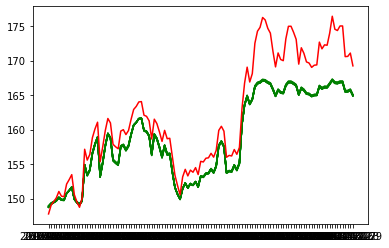

In [14]:
plt.plot(df.loc[2900:,'Date'],predict, color = "green")
plt.plot(df.loc[2900:,'Date'],test, color = "red")